#Algunas funciones utiles

In [1]:
PCA_mat<-function(dat){
#Esta funcion te devuelve la matriz cambio de base del PCA
  mat_cov<-cov(dat)
  eig<-eigen(mat_cov)
  mat_cb<-solve(eig$vectors) 

  return(mat_cb)
}

In [2]:
feature.select<-function(x,y,n.feat){
#Esta funcion selecciona los features usando un bineado
  xbin=(max(x)-min(x))/(n.feat)

  y.feat<-1:n.feat
  x.feat<-1:n.feat

  for(i in 1:n.feat){
    x.feat[i]=min(x)+xbin*(2*(i-1)+1)/2
    xmin=x.feat[i]-xbin/2
    xmax=x.feat[i]+xbin/2
    y.feat[i]=mean(y[which(x>=xmin & x<xmax)])
  }

  mat<-data.frame(x.feat,y.feat)
}


#Leyendo los datos del cmb 

In [3]:
params<-read.table('/media/martin/store1/programas/camb/camb/real_params.dat',header=T)
n.feat=40
vec<-c('l','Ctt','Cee','Cte','cfi','cfit')
mat<-matrix(1:(length(params$om)*n.feat),ncol=n.feat)

for(i in 1:length(params$om)){
  name=paste('/media/martin/store1/programas/camb/camb/cmb_',toString(i),'_scalCls.dat',sep='')

 dat<-read.table(name,col.names=vec)
 error.unif<-1:length(dat$Ctt)
 error.norm<-1:length(dat$Ctt)
 for(j in 1:length(dat$Ctt)){
  cos_var=sqrt(2/(2*dat$l[j]+1))*dat$Ctt[j]
  error.unif[j]<-runif(1,min=-cos_var,max=cos_var)
  error.norm[j]<-rnorm(1,mean=0,sd=cos_var)
 }
 Ctt.err.unif=dat$Ctt+error.unif
 Ctt.err.norm=dat$Ctt+error.norm
 dat<-data.frame(dat,Ctt.err.unif,Ctt.err.norm)
 dat<-subset(dat,dat$l>29)
 datos_aux<-feature.select(dat$l,dat$Ctt.err.norm,n.feat=n.feat)
 
 mat[i,]=datos_aux$y.feat

}
datos<-data.frame(mat)

om<-params$om
ol<-params$ol
ob<-params$ob
H<-params$H


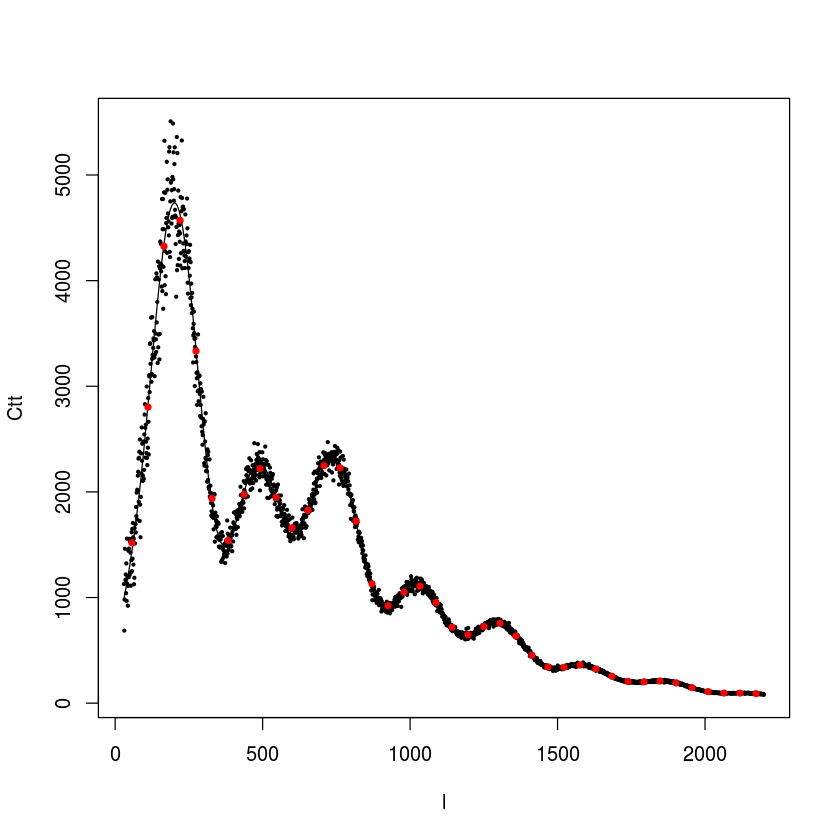

In [12]:
#Graficos de algunos espectros y los features

plot(dat$l,dat$Ctt.err.norm,pch=20,col='black',xlab='l',
    ylab='Ctt',cex=0.5)
lines(dat$l,dat$Ctt,typ='l')
points(datos_aux$x.feat,datos_aux$y.feat,pch=20,col='red')

#PCA

In [13]:
pca<-princomp(datos,cor=F)
mat_camb.base<-PCA_mat(datos)
medias<-sapply(datos,mean)
summary(pca)

Importance of components:
                             Comp.1      Comp.2       Comp.3       Comp.4
Standard deviation     2011.1593485 826.3730650 564.23737563 500.82650023
Proportion of Variance    0.7392591   0.1248119   0.05818719   0.04584356
Cumulative Proportion     0.7392591   0.8640710   0.92225815   0.96810171
                             Comp.5       Comp.6       Comp.7       Comp.8
Standard deviation     298.93257450 186.98337620 1.511343e+02 1.008864e+02
Proportion of Variance   0.01633241   0.00639013 4.174741e-03 1.860241e-03
Cumulative Proportion    0.98443411   0.99082424 9.949990e-01 9.968592e-01
                             Comp.9      Comp.10      Comp.11      Comp.12
Standard deviation     6.585089e+01 6.050365e+01 43.976819405 3.928595e+01
Proportion of Variance 7.925505e-04 6.690627e-04  0.000353469 2.820839e-04
Cumulative Proportion  9.976518e-01 9.983208e-01  0.998674307 9.989564e-01
                            Comp.13      Comp.14      Comp.15      Comp.16
Sta

In [15]:
#Vemos que las 6 primeras componentes son las mas importantes
datos<-pca$scores[,c(1,2,3,4,5,6)] 
datos<-data.frame(om,ol,ob,H,datos)

#Machine Learning Algorithms

##Redes Neuronales

In [16]:
library('neuralnet')

#Armamos los set de entrenamiento y testeo
ntrain=length(datos$om)-floor(length(datos$om)/8) #Numero de instancias del trainset
train_ind<-sample(1:length(datos$om),size=ntrain,replace=FALSE)
trainset<-datos[train_ind,]
testset<-datos[-train_ind,]

#Armamos el modelo de red
net<-neuralnet((om+ol+ob+H)~(Comp.1+Comp.2+Comp.3+Comp.4+Comp.5+Comp.6),trainset,hidden=6,rep=10)

#Predecimos nuevos resultados sobre el set de testeo
om_real=testset$om
ol_real=testset$ol
ob_real=testset$ob
H_real=testset$H
testset<-testset[,-c(1,2,3,4)]
net_results<-compute(net,covariate=testset)
om.pred=net_results$net.result[,1]
ol.pred=net_results$net.result[,2]
ob.pred=net_results$net.result[,3]
H.pred=net_results$net.result[,4]


Loading required package: grid
Loading required package: MASS
Warning message:
: algorithm did not converge in 9 of 10 repetition(s) within the stepmax

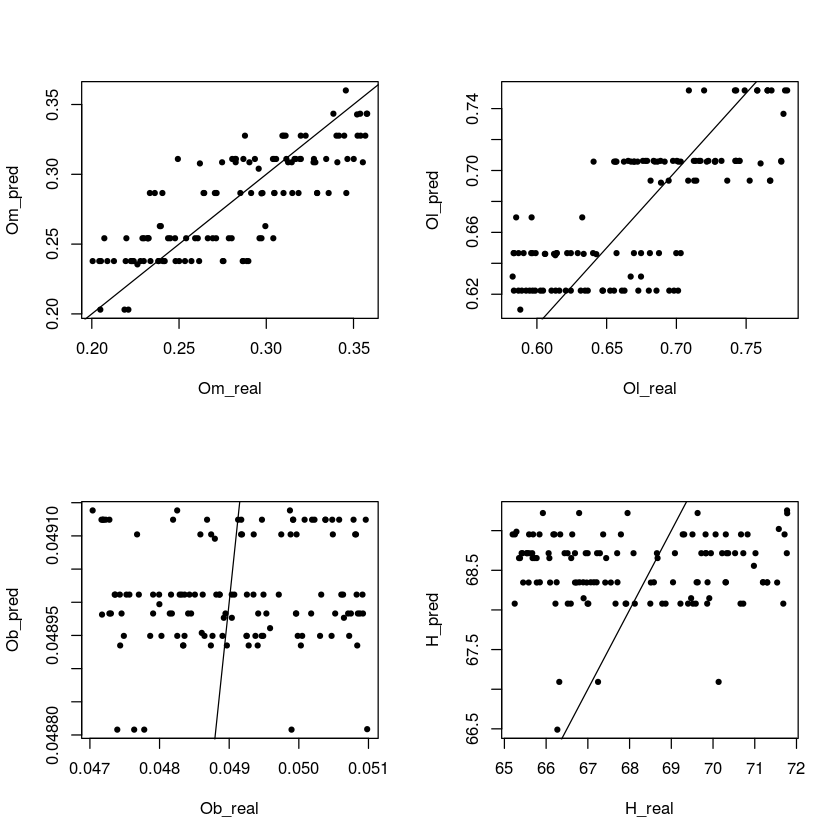

In [17]:
par(mfrow=c(2,2))
plot(om_real,om.pred,pch=20,xlab='Om_real',ylab='Om_pred')
abline(a=0,b=1)
plot(ol_real,ol.pred,pch=20,xlab='Ol_real',ylab='Ol_pred')
abline(a=0,b=1)
plot(ob_real,ob.pred,pch=20,xlab='Ob_real',ylab='Ob_pred')
abline(a=0,b=1)
plot(H_real,H.pred,pch=20,xlab='H_real',ylab='H_pred')
abline(a=0,b=1)